## 1. Select and document key parameters/columns

| Column / Tag              | Description / Notes                                        |
|---------------------------|------------------------------------------------------------|
| clinic_id / osmid         | Unique OSM identifier for the object.                      |
| clinic_name / name        | Clinic name.                                               |
| amenity                   | Should be `veterinary` for all rows.                       |
| street / addr:street      | Street name.                                               |
| house_number / addr:housenumber | House number.                                        |
| postcode / addr:postcode  | Postal code.                                               |
| city / addr:city          | City/locality.                                             |
| district_id (FK)          | District in which the clinic is located.                   |
| neighbourhood_id (FK)     | Neighbourhood in which the clinic is located.              |
| phone_number / phone      | Contact phone number(s).                                   |
| website                   | Website URL.                                               |
| email                     | E-mail address.                                            |
| opening_hours             | Structured opening hours.                                  |
| operator                  | Organisation running the clinic.                           |
| speciality                | Specialisation on certain topics.                          |
| wheelchair_acces          | Yes, no, or limited access granted.                        |
| full_address              | Full address instead of separate street/number/code/city.  |
| latitude                  | Point or polygon geometry (latitude).                      |
| longitude                 | Point or polygon geometry (longitude).                     |


## 2. Define how this data connects to existing tables

| Existing Table                                | Connection Logic                                                                                             |
| --------------------------------------------- | ------------------------------------------------------------------------------------------------------------ |
| **Districts** (Berlin’s administrative areas) | Spatial join: point-in-polygon from clinic geometry to district polygon. Add `district_id` foreign key.      |
| **Neighborhoods**                             | Same: spatial join from clinic geometry to neighborhood boundary polygon. Add `neighborhood_id` foreign key. |


## 3. Draft and document the planned schema for the new table.


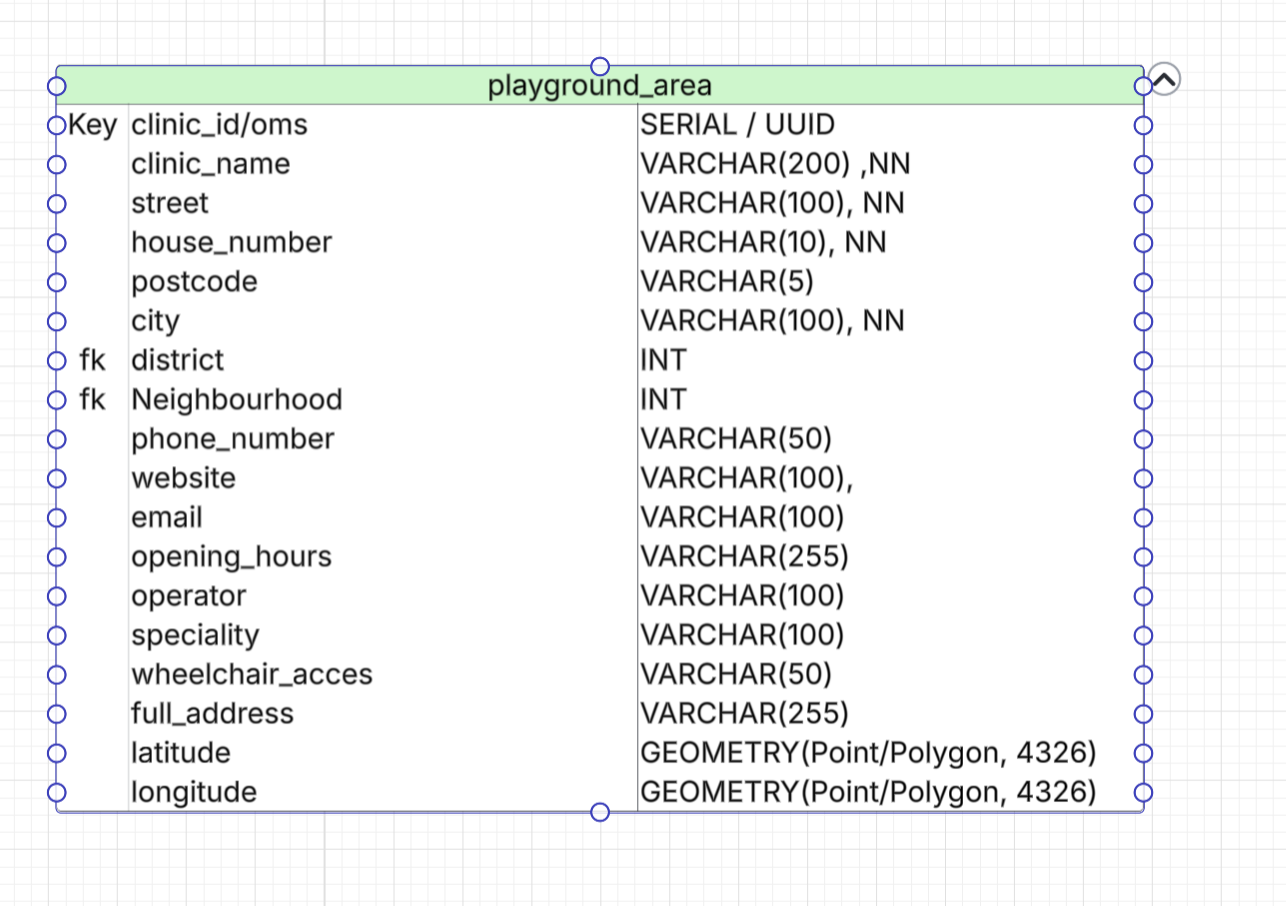

In [6]:
from IPython.display import Image, display

# Display a JPEG image from a file path or URL
display(Image(filename='/Users/martinsvitek/layered-populate-data-pool-da/layered-populate-data-pool-da/vet_clinics/sources/erd_vet_clinics.png'))


In [5]:
import os
print(os.getcwd())


/Users/martinsvitek/layered-populate-data-pool-da/layered-populate-data-pool-da/vet_clinics/sources



## 4. List known data issues or inconsistencies

Typical for OSM-derived data:

-   **Missing values**: Many clinics lack `addr:housenumber`, `phone`, `website`, or `opening_hours`.
    
-   **Multiple tags**: Phone numbers may appear under `phone` or `contact:phone`; same for website and email.
    
-   **Format differences**: Phone numbers and postcodes in different formats (international codes, hyphens, spaces).
    
-   **Duplicate entries**: Some clinics may be mapped twice (once as a node and once as a building polygon).
    
-   **Geometry types**: Some records are points, others polygons; you may need to normalize to a centroid for joins.
    
-   **Outdated information**: OSM data is crowd-sourced; closures or relocations may not be reflected immediately.
    
-   **Spelling/normalization**: Names and operators may be spelled inconsistently.
    

----------


## 5. Outline the transformation plan (cleaning, normalization, structure, etc.)

# 0) Ingestion & scope

-   Ingest via OSMnx (2.x): `ox.features_from_place('Berlin, Germany', tags={'amenity':'veterinary'})`
    
-   Keep nodes + ways/relations (ways/relations → polygon/centroid handling below)
    
-   Snapshot & cache the raw pull (parquet/geojson) for reproducibility
    
    

# 1) Column pruning & renaming

**Keep**: `osmid, name, amenity, addr:street, addr:housenumber, addr:postcode, addr:city, phone, contact:phone, website, contact:website, email, contact:email, opening_hours, operator, brand, veterinary:speciality, wheelchair, emergency, geometry`

**Rename → target schema**

-   `clinic_id/osmid` ← `osmid`
    
-   `clinic_name/name` ← `name`
    
-   `street` ← `addr:street`
    
-   `house_number` ← `addr:housenumber`   
-   `postcode` ← `addr:postcode`   
-   `city` ← `addr:city`
-    `district_id`
-    `neighbourhood_id`    
-   `phone_number` ← coalesce(`contact:phone`, `phone`)   
-   `website` ← coalesce(`contact:website`, `website`)  
-   `email` ← coalesce(`contact:email`, `email`)
-    `opening_hours`
-    `operator`    
-   `speciality` ← `veterinary:speciality`    
-   `wheelchair_acces` ← `wheelchair`
-    `full_address`
-    `latitude`
-    `longitude`    
-   `amenity` should be `veterinary` (filter check)
    

# 2) Geometry normalization

-   If geometry is **Point** → keep
    
-   If **Polygon/MultiPolygon** → compute centroid for point-based joins/analysis; retain original geometry if you need building footprint later
    
-   Set CRS to EPSG:4326
    

# 3) Data cleaning

**Strings**

-   Strip whitespace, normalize Unicode, collapse repeated spaces  
-   Lowercase only when appropriate (not for proper names/streets)   

**Phone**

-   Canonicalize: remove spaces/dashes, keep leading `+` if present   
-   Optional: format to E.164 if country is known (DE → `+49`)   

**Website**

-   Ensure scheme: prepend `https://` if missing; drop obvious junk
    

**Email**

-   Basic pattern check; lowercase domain    

**Postcode**

-   Keep as text; left-pad if needed (e.g., 5 digits for DE) not sure about this yet, postalcode as number for search
    
**opening_hours**

-   Keep raw string; optionally validate with an opening-hours parser (e.g., `pyopening_hours`)    

**operator/brand**

-   Trim, title-case; prepare for reference matching
    

**wheelchair/emergency**

-   Map to controlled set: `yes | no | limited` and `yes | no`
    

# 4) De-duplication

-   Node vs polygon duplicates:
    
    -   Spatial proximity (<= 20–30 m) **and** name similarity (e.g., fuzzy ratio ≥ 90) → treat as same clinic
        
    -   Prefer the polygon record for address context, but keep the point geometry for joins/labeling
        
-   Exact duplicates on `osmid` → drop
    

# 5) Address enrichment & full address

-   Build `full_address` as:
    
    -   `"{street} {house_number}, {postcode} {city}"` (only include non-null parts, single spaces/commas)
        

# 6) Spatial keys (district / neighbourhood)

-   Load official Berlin **districts** and **Ortsteile** boundaries (CRS: 4326)
    
-   **Point-in-polygon** with centroid:
    
    -   assign `district_id`, `neighbourhood_id`
        
-   If outside any polygon: flag `geo_out_of_bounds = true` for QA
    

# 7) Conformance to target schema

-   Types (example, PostgreSQL/PostGIS):
    
    -   `clinic_id` → UUID (or `osmid` BIGINT as natural key)
        
    -   `clinic_name` → `VARCHAR(200)` NN if required
        
    -   address fields → `VARCHAR`
        
    -   `phone_number` → `VARCHAR(50)`
        
    -   `website`, `email` → `VARCHAR(255)`
        
    -   `opening_hours` → `VARCHAR(255)`
        
    -   FK: `district_id`, `neighbourhood_id` → `INT` (reference tables)
        
    -   `geometry` → `GEOMETRY(Point, 4326)`
        
-   Create functional indexes:
    
    -   `GIN`/`btree` on `operator`, `postcode`, `district_id`
        
    -   `GIST` on `geometry`
        

# 8) Business rules & validations (tests)

-   **Amenity check**: all rows must have `amenity = 'veterinary'`
    
-   **Not-nulls** (decide policy): `clinic_id`, `geometry`, `city`
    
-   **Phone**: only digits, spaces, `+`, `()` and `-`
    
-   **Website**: must start with `http` or be null
    
-   **Opening hours**: parseable or null
    
-   **Spatial**: 100% within Berlin districts unless flagged
    
-   **Duplicates**: post-dedupe no pairs within X m with same normalized name
    

# 9) Operators reference table (optional)

-   Build `operators(dim)` with `operator_id`, `operator_name`, `brand`
    
-   Match clinics → `operator_id` by normalized `operator/brand`
    
-   Handle “unknown” bucket
    

# 10) Output artifacts

-   **Gold table**: `marts.vet_clinics` (one row per clinic, point geometry)
    
-   **Supplement**: `marts.vet_clinics_areas` (optional polygon footprints)
    
-   **Exports**: CSV (no geometry), GeoJSON (with geometry)
    

# 11) Known issues to track

-   Missing address/contact/opening_hours on many rows
    
-   Node/area duplication
    
-   Informal neighborhood vs official Ortsteil boundaries
    
-   Outdated listings (closures/moves)
    
-   Inconsistent phone and website formats
    
-   Specialities free-text & multilingual
    
-   Wheelchair/emergency incompletely tagged
    

----------


```

**Spatial join (concept)**

-   Load districts & neighbourhoods as GeoDataFrames
    
-   `gpd.sjoin(gdf.set_geometry('geometry'), districts, how='left', predicate='within')`
    
-   Assign `district_id`, then repeat for neighbourhoods
    

----------

## Acceptance criteria (quick checklist)

-   100% `amenity='veterinary'`
    
-   No duplicate clinics (name+distance rule)
    
-   ≥ X% rows have `street` + `housenumber` + `postcode` + `city`
    
-   Validated `website`/`email` formats
    
-   `district_id` & `neighbourhood_id` populated for ≥ 99% of points
    
-   Geometry CRS is EPSG:4326; centroids used for polygons
    
-   Exports produced: CSV (attribs), GeoJSON (with geometry)
    



----------

In [3]:
pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 2.5 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 2.7 MB/s  0:00:07 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 3.0 MB/s  0:00:01 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 3.1 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11/11 [osmnx]m 9/11 [geopandas]
Note: you may need to restart the kernel to use updated packages.


In [12]:
import osmnx as ox
import pandas as pd  

pd.set_option('display.max_columns', None)  # Show all columns

# get all vet clinics in Berlin

# for OSMnx 2.x:
gdf = ox.features_from_place(
    'Berlin, Germany',
    tags={'amenity': 'veterinary'}
)
gdf.to_file('berlin_vets.geojson', driver='GeoJSON')

gdf.head()

geometry addr:city addr:housenumber  \
element id                                                                
node    268917040  POINT (13.40523 52.49568)    Berlin               69   
        299795048  POINT (13.47955 52.60629)    Berlin               67   
        347294456  POINT (13.32013 52.42972)    Berlin               36   
        394867279   POINT (13.27057 52.5352)       NaN              NaN   
        411550894  POINT (13.58964 52.50951)    Berlin               19   

                  addr:postcode          addr:street     amenity  \
element id                                                         
node    268917040         10961       Baerwaldstraße  veterinary   
        299795048         13125            Straße 48  veterinary   
        347294456         12207  Königsberger Straße  veterinary   
        394867279           NaN                  NaN  veterinary   
        411550894         12621        Planitzstraße  veterinary   

                                                   name  \
element id                                                
node    268917040               Tierarztpraxis am Urban   
        299795048            Dr. med. vet. Elke Hartwig   
        347294456  Tierarztpraxis Dr. Bernhard Sörensen   
        394867279       Tierarztpraxis Jeanette Koepsel   
        411550894  Kleintierarztpraxis Berlin Kaulsdorf   

                                          note  \
element id                                       
node    268917040  Städt. Kita Baerwaldstr. 69   
        299795048                          NaN   
        347294456                          NaN   
        394867279                          NaN   
        411550894                          NaN   

                                                       opening_hours  \
element id                                                             
node    268917040  Mo-Sa 10:00-12:00, Mo 17:00-19:00, Tu,We,Fr 16...   
        299795048         Mo,Tu,Th,Fr 10:00-12:00, Mo-Fr 15:00-18:00   
        347294456              Mo-Fr 09:00-20:00; Sa, Su 10:00-18:00   
        394867279                                                NaN   
        411550894  Mo-Fr 09:00-19:00 open "tel. Terminvereinbarun...   

                  wheelchair addr:country   addr:suburb            phone  \
element id                                                                 
node    268917040         no          NaN           NaN              NaN   
        299795048    limited           DE         Karow   +49 30 9437820   
        347294456        yes           DE  Lichterfelde   +49 30 7738321   
        394867279        NaN          NaN           NaN              NaN   
        411550894        NaN           DE     Kaulsdorf  +49 30 53018585   

                                                    website  \
element id                                                    
node    268917040                                       NaN   
        299795048     http://www.tierarztpraxis-hartwig.de/   
        347294456  https://www.tierarztpraxis-soerensen.de/   
        394867279                                       NaN   
        411550894        https://www.tierarzt-kaulsdorf.de/   

                  toilets:wheelchair                       email  \
element id                                                         
node    268917040                NaN                         NaN   
        299795048                NaN                         NaN   
        347294456                 no                         NaN   
        394867279                NaN                         NaN   
        411550894                NaN  info@tierarzt-kaulsdorf.de   

                                                            facebook  \
element id                                                             
node    268917040                                                NaN   
        299795048                                                NaN   
        347294456      

In [14]:
gdf.info()
gdf.describe()


<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 170 entries, ('node', np.int64(268917040)) to ('way', np.int64(286010852))
Data columns (total 75 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   geometry                         170 non-null    geometry
 1   addr:city                        111 non-null    object  
 2   addr:housenumber                 124 non-null    object  
 3   addr:postcode                    113 non-null    object  
 4   addr:street                      124 non-null    object  
 5   amenity                          170 non-null    object  
 6   name                             164 non-null    object  
 7   note                             1 non-null      object  
 8   opening_hours                    123 non-null    object  
 9   wheelchair                       81 non-null     object  
 10  addr:country                     87 non-null     object  
 11  addr:subur

,geometry,addr:city,addr:housenumber,addr:postcode,addr:street,amenity,name,note,opening_hours,wheelchair,addr:country,addr:suburb,phone,website,toilets:wheelchair,email,facebook,fax,instagram,operator,emergency,source,contact:email,contact:fax,contact:mobile,contact:phone,contact:website,wheelchair:description,check_date,check_date:opening_hours,url,description,addr:floor,level,opening_hours:url,contact:email_1,name:de,payment:cash,indoor:level,veterinary:treats:cat,note:de,contact:facebook,veterinary,veterinary:treats:bird,veterinary:treats:dog,veterinary:treats:reptile,veterinary:treats:small_mammals,contact:instagram,start_date,reservation,internet_access,payment:credit_cards,payment:debit_cards,language:en,language:ru,language:tr,dog,survey:date,opening_hours:signed,building,building:levels,fee,roof:shape,architect,architect:wikidata,heritage,heritage:operator,lda:criteria,old_name,ref:lda,wikidata,wikimedia_commons,roof:levels,historic,source:shape
count,170,111,124,113,124,170,164,1,123,81,87,79,71,80,6,17,1,10,1,38,3,7,12,5,2,24,24,3,33,31,1,8,2,12,1,1,2,2,1,2,1,1,3,2,1,2,1,1,3,1,1,2,3,1,1,1,1,1,1,7,3,1,3,1,1,2,1,1,1,1,2,1,1,1,1
unique,170,1,74,84,120,1,161,1,119,3,1,42,71,79,1,17,1,10,1,38,2,5,12,5,2,24,24,3,33,31,1,8,2,2,1,1,2,1,1,2,1,1,2,1,1,1,1,1,3,1,1,1,1,1,1,1,1,1,1,2,2,1,1,1,1,2,1,1,1,1,2,1,1,1,1
top,POINT (13.4052329 52.4956842),Berlin,3,12159,Ernststraße,veterinary,Tierarztpraxis,Städt. Kita Baerwaldstr. 69,24/7,no,DE,Wilmersdorf,+49 30 9437820,https://www.rex.app/,no,info@tierarzt-kaulsdorf.de,https://www.facebook.com/Dr.M.Kochert.und.Dr.B...,+49 30 5637506,https://www.instagram.com/tierarztpraxiskaulsd...,Dr. Berit Miels;Dr. Mathias Kochert,yes,Geoportal Berlin / Hauskoordinaten,info@kleintierpraxis-kladow.de,+49 30 36991083,+49 163 2386867,+49 30 3653374,http://www.kleintierpraxis-kladow.de,"Eine Stufe, schmale Tür zum Behandlungsraum",2025-05-11,2025-06-09,http://www.tierarztpraxis-torres.de,Notrufnummer +49 174 160 160 6,1,0,https://tierarztpraxis-am-lietzenseepark.de/sp...,info@ta-krause.de,Tiergesundheitszentrum,yes,0,only,"Sprechstunde Mo-Fr 8-19, Sa 9-13;Notdienst Sa ...",https://www.facebook.com/TierarztpraxisChungun...,practice,yes,yes,yes,yes,https://www.instagram.com/wolfandtiger_de/,2021-09-01,required,no,yes,yes,yes,yes,yes,leashed,2023-07-18,no,yes,1,yes,flat,W. Helmsdorff,Q110768840,4,lda,Baudenkmal,Bauernhof Großkopf,09011742,Q15107420,Category:Bauernhof Großkopf,0,building,Geoportal Berlin / Hausumringe
freq,1,111,7,4,2,170,3,1,3,42,87,8,1,2,6,1,1,1,1,1,2,3,1,1,1,1,1,1,1,1,1,1,1,11,1,1,1,2,1,1,1,1,2,2,1,2,1,1,1,1,1,2,3,1,1,1,1,1,1,4,2,1,3,1,1,1,1,1,1,1,1,1,1,1,1


In [15]:

# suppose gdf is your GeoDataFrame from OSMnx
cols = list(gdf.columns)
print(cols)


['geometry', 'addr:city', 'addr:housenumber', 'addr:postcode', 'addr:street', 'amenity', 'name', 'note', 'opening_hours', 'wheelchair', 'addr:country', 'addr:suburb', 'phone', 'website', 'toilets:wheelchair', 'email', 'facebook', 'fax', 'instagram', 'operator', 'emergency', 'source', 'contact:email', 'contact:fax', 'contact:mobile', 'contact:phone', 'contact:website', 'wheelchair:description', 'check_date', 'check_date:opening_hours', 'url', 'description', 'addr:floor', 'level', 'opening_hours:url', 'contact:email_1', 'name:de', 'payment:cash', 'indoor:level', 'veterinary:treats:cat', 'note:de', 'contact:facebook', 'veterinary', 'veterinary:treats:bird', 'veterinary:treats:dog', 'veterinary:treats:reptile', 'veterinary:treats:small_mammals', 'contact:instagram', 'start_date', 'reservation', 'internet_access', 'payment:credit_cards', 'payment:debit_cards', 'language:en', 'language:ru', 'language:tr', 'dog', 'survey:date', 'opening_hours:signed', 'building', 'building:levels', 'fee', 'ro

In [16]:
# if gdf is a GeoDataFrame and you just want the attribute table
gdf.drop(columns='geometry').to_csv('berlin_vets.csv', index=False)


In [17]:
import os
print(os.getcwd())  # shows the directory where the file was written



/Users/martinsvitek/layered-populate-data-pool-da/layered-populate-data-pool-da
